In [25]:
import pickle
from math import floor
from IPython.display import display, clear_output
import scipy.stats
from pylab import * 
import numpy as np
import seaborn as sns
import pandas
from itertools import product as iterproduct, groupby
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/analysis_lib.ipynb"
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})
matplotlib.rcParams.update({'font.size': 16})

In [26]:
# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_alignment_true_events.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/david_eccles_bc_ideas/mouse_ref.fa",
# }

args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_alignment_true_events.pickle",
    "ref": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_ref.fasta",
}

In [27]:
NMER = 3
CONTEXT = 200

In [28]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks/04_error_correction


In [29]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [30]:
ref_file = args["ref"]
test = !cat {ref_file} | grep ">"
print(test)
ref = !cat {ref_file} | grep -v ">"
ref = ref[0]
print(ref[:100])

['>burn-in lambda_ref']
GGGCGGCGACCTCGCGGGTTTTCGCTATTTATGAAAATTTTCCGGTTTAAGGCGTTTCCGTTCTTCTTCGTCATAACTTAATGTTTTTATTTAAAATACC


In [31]:
def get_context(event, start, end):
    """get the nt-context around the kmer. 
    E.g. start=-20: get context 20nt before the reference point
    (mid of kmer)"""
    ref_pos = event["ref_position"]
    start = ref_pos + start
    end = ref_pos + end
    context = ref[start:end]
    if len(context) != end-start:
        raise IndexError
    else: return context

def get_context_before(event, n):
    """get n nucleotides before the start of the kmer"""
    length = len(event["kmer"])
    offset = int(-floor(length/2))
    return get_context(event, -n+offset, offset)
    
def get_context_after(event, n):
    length = len(event["kmer"])
    offset = int(floor(length/2) + 1)
    return get_context(event, offset, offset+n)

In [32]:
test_event = true_events[0]
assert test_event['kmer'] == get_context(test_event, -2, 2+1), "invalid reference"
assert (get_context_before(test_event, 20) 
        + test_event['kmer'] 
        + get_context_after(test_event, 20)) == (
    get_context(test_event, -22, 22+1))

## Analysis 

In [33]:
all_5mers = mk_kmer_dict(NMER)
ev_map = mk_event_map(true_events, all_5mers)

In [57]:
template_events = [ev for ev in ev_map["TCT"] if not np.isnan(ev["template.mean"])]
template_events = [ev for ev in template_events if 
                   ev["ref_position"] > CONTEXT and ev["ref_position"] < len(ref)-CONTEXT]
means = [ev["template.mean"] for ev in template_events]
stdvs = [ev["template.stdv"] for ev in template_events]
context_before = [get_context_before(ev, 200) for ev in template_events]
context_after = [get_context_after(ev, 200) for ev in template_events]

### stratify by genomic position to remove sequence bias

In [58]:
print(len(set([ev["ref_position"] for ev in template_events])))
print(len(template_events))

643
55636


skipped 13541
skipped 26924


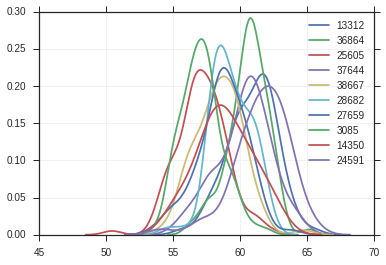

In [59]:
template_events = sorted(template_events, key=lambda x: x["ref_position"])
groups = {key: [x for x in group] for key, group in groupby(template_events, lambda x: x["ref_position"])}
genomic_pos = OrderedDict()
for key, group in groups.items():
    means = [x["template.mean"] for x in group]
    if(len(means) < 10): 
        print("skipped {0}".format(key))
        continue
    else:
        assert get_context_before(group[0], 200) == get_context_before(group[-1], 200)
        genomic_pos[key] = {
            "event_means" : means,
            "mean" : np.mean(means),
            "stdv" : np.std(means),
            "context_before": get_context_before(group[0], 200),
            "context_after": get_context_after(group[0], 200)
        }

for key, ev_means in [(k, v["event_means"]) for k, v in genomic_pos.items()][:10]:
    sns.distplot(ev_means, hist=False, label=str(key))


=> there are siginificant differences between the genomic positions, both in mean and in stdv.

=> some are limited to a very narrow range, while others are scattered over a wider range

=> **genomic_pos** is a dict genomic_position -> mean of the kmers at this position

/home/sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


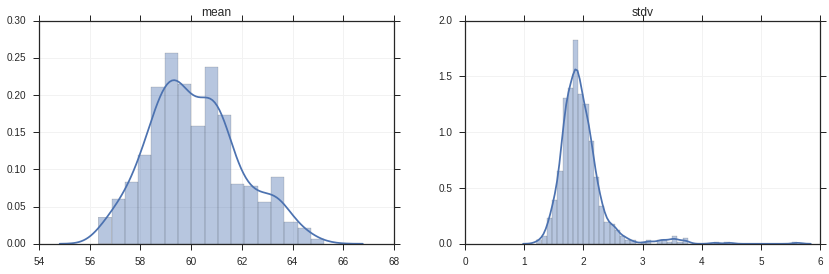

In [60]:
fig, (ax1, ax2) = subplots(1, 2, figsize=(14,4))
sns.distplot([x["mean"] for x in genomic_pos.values()], ax=ax1)
ax1.set_title("mean")
sns.distplot([x["stdv"] for x in genomic_pos.values()], ax=ax2)
ax2.set_title("stdv")
fig.show()

### Plot relation current / nucleotides

In [61]:
def nt_dict(nts, values):     
    d = OrderedDict(((nt, []) for nt in NT_RMAP.values()))
    for nt, val in zip(nts, values): 
        d[NT_RMAP[nt]].append(val)
    return d

In [62]:
context = {}
distance_means = {}
distance_distrib = {}
for t in ["before", "after"]:
    distance_distrib[t] = []
    for d in range(200):
        context[t] = [p["context_{0}".format(t)] for p in genomic_pos.values()]
        curr_nt = [NT_MAP[x[-1-d]] for x in context[t]]
        nt_distrib = nt_dict(curr_nt, [p["mean"] for p in genomic_pos.values()])
        distance_distrib[t].append(nt_distrib)
    distance_means[t] = [{k: np.mean(v) for k, v in d.items()} for d in distance_distrib[t]]

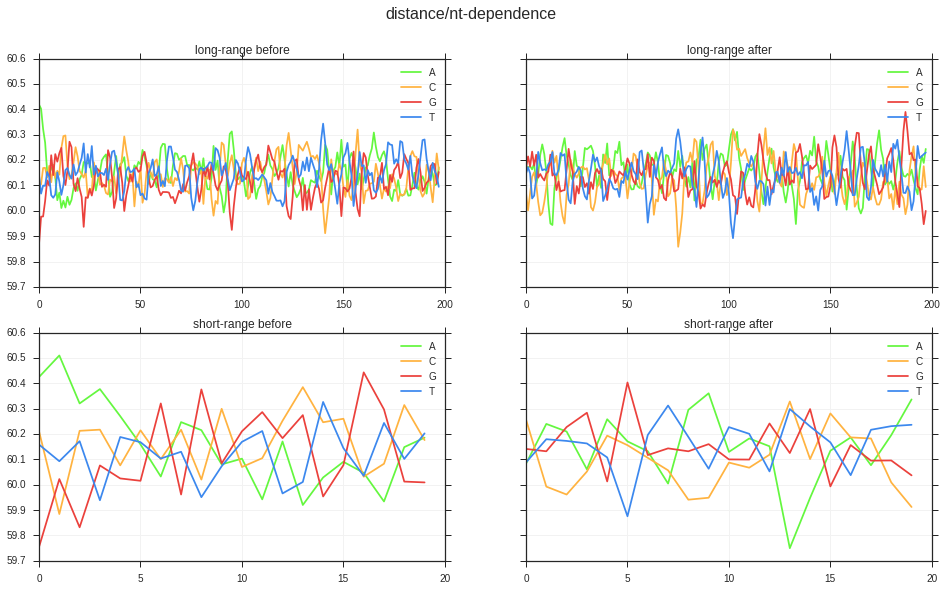

In [63]:
fig, ((ax1, ax2), (ax3, ax4)) = subplots(2, 2, figsize=(16, 9), sharey=True)
axis = {
    "before" : (ax1, ax3),
    "after" : (ax2, ax4)
}
fig.suptitle("distance/nt-dependence".format(t))


for t in ["before", "after"]:
    for nt in "ACGT":
        data = [d[nt] for d in distance_means[t]]
        data_smoothed = [np.mean((data[i], data[i+1], data[i+2])) for i in range(len(data)-2)]
        axis[t][0].plot(range(len(data_smoothed)), data_smoothed, color=NT_COLORS[nt], label=nt)
        axis[t][0].set_title("long-range {0}".format(t))
        axis[t][1].plot(range(20), data[:20], color=NT_COLORS[nt], label=nt)
        axis[t][1].set_title("short-range {0}".format(t))
        axis[t][0].legend()
        axis[t][1].legend()


apparently, before is more important than after, an also there only the first position. => 4mer? 

,A,C,G,T
A,1.000000,0.290563,0.000525,0.134881
C,0.290563,1.000000,0.041237,0.793356
G,0.000525,0.041237,1.000000,0.038479
T,0.134881,0.793356,0.038479,1.000000
,A,C,G,T
A,1.000000,0.385613,0.762073,0.979299
C,0.385613,1.000000,0.565851,0.405007
G,0.762073,0.565851,1.000000,0.784656
T,0.979299,0.405007,0.784656,1.000000


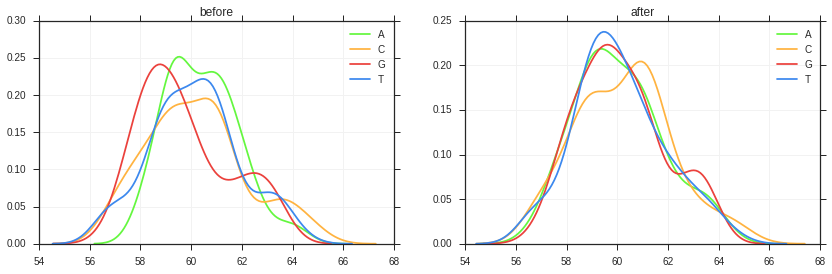

,A,C,G,T
A,1.000000,0.001451,0.020470,0.021745
C,0.001451,1.000000,0.525198,0.270270
G,0.020470,0.525198,1.000000,0.726780
T,0.021745,0.270270,0.726780,1.000000
,A,C,G,T
A,1.000000,0.243220,0.595766,0.750701
C,0.243220,1.000000,0.502400,0.335579
G,0.595766,0.502400,1.000000,0.798488
T,0.750701,0.335579,0.798488,1.000000


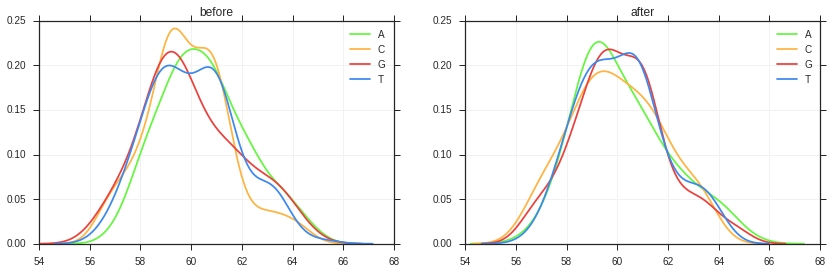

,A,C,G,T
A,1.000000,0.601429,0.007899,0.441254
C,0.601429,1.000000,0.057731,0.847600
G,0.007899,0.057731,1.000000,0.074583
T,0.441254,0.847600,0.074583,1.000000
,A,C,G,T
A,1.000000,0.211477,0.930356,0.853941
C,0.211477,1.000000,0.169991,0.274732
G,0.930356,0.169991,1.000000,0.780521
T,0.853941,0.274732,0.780521,1.000000


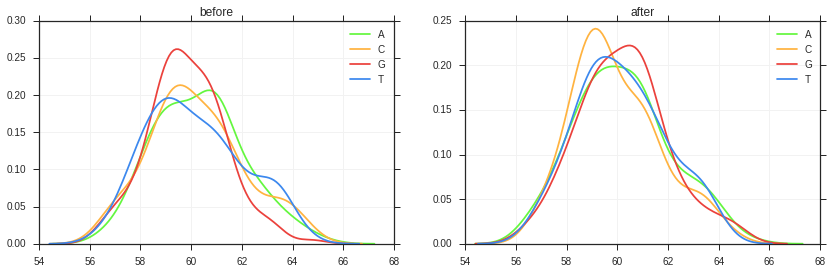

In [64]:
for d in range(3):
    fig, (ax1, ax2) = subplots(1, 2, figsize=(14,4));
    axis = {"before": ax1, "after": ax2}
    matrices = OrderedDict()
    for t in ["before", "after"]:
        distrib = distance_distrib[t][d]
        matrix = {nt: {} for nt in distrib.keys()}
        for A, B in iterproduct(distrib.items(), repeat=2):
            test = scipy.stats.ttest_ind(A[1], B[1])
            matrix[A[0]][B[0]] = test[1]
        matrices[t] = (pandas.DataFrame(matrix))
        for nt, nt_mean in distrib.items():
            axis[t].set_title(t);
            sns.distplot(nt_mean, hist=False, label=nt, color=NT_COLORS[nt], ax=axis[t]);
           
                
    display(side_by_side(*matrices.values()))
    display(fig);  
    plt.close()
    


only the first position of "before" show significant results.